In [5]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models

In [46]:
# Unzip dataset
with zipfile.ZipFile('/Users/himanshumaurya/Desktop/Sem 5/Data Analytics/DAV lab/DATA SET.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

# Set paths
base_dir = 'data'
smoker_dir = os.path.join(base_dir, 'smoker')
nonsmoker_dir = os.path.join(base_dir, 'non-smoker')

# Get image paths and labels (include .jpg and .png)
image_paths = glob(smoker_dir + '/*.jpg') + glob(smoker_dir + '/*.png') + \
              glob(nonsmoker_dir + '/*.jpg') + glob(nonsmoker_dir + '/*.png')
labels = [1]* (len(glob(smoker_dir + '/*.jpg')) + len(glob(smoker_dir + '/*.png'))) + \
         [0]* (len(glob(nonsmoker_dir + '/*.jpg')) + len(glob(nonsmoker_dir + '/*.png')))

# Create DataFrame
df = pd.DataFrame({'image': image_paths, 'label': labels})

In [30]:
#Face Detection and Alignment using MTCNN
from mtcnn.mtcnn import MTCNN
import cv2
import numpy as np
import matplotlib.pyplot as plt

detector = MTCNN()

def detect_and_align_face(image_path, output_size=(128, 128)):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Image not found or unable to read: {image_path}")
        return None
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = detector.detect_faces(img_rgb)
    if result:
        x, y, w, h = result[0]['box']
        # Ensure coordinates are within image bounds
        x, y = max(0, x), max(0, y)
        face = img_rgb[y:y+h, x:x+w]
        face = cv2.resize(face, output_size)
        return face
    else:
        print(f"No face detected in {image_path}")
        return None

# Example usage with an actual image from your folder
face_img = detect_and_align_face('data/smoker/smoker_61.png')
if face_img is not None:
    plt.imshow(face_img)
    plt.title('Aligned Face')
    plt.axis('off')
    plt.show()

Image not found or unable to read: data/smoker/smoker_61.png


[ WARN:0@867.800] global loadsave.cpp:268 findDecoder imread_('data/smoker/smoker_61.png'): can't open/read file: check file path/integrity


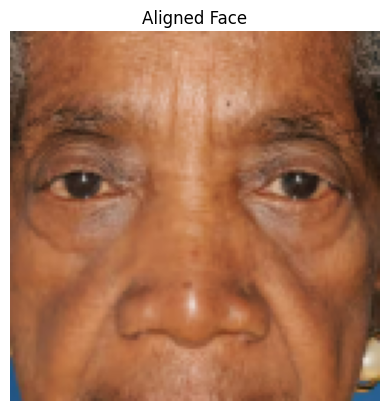

In [32]:
#Face Detection and Alignment using OpenCV Haar Cascades
import cv2

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_and_align_face_opencv(image_path, output_size=(128, 128)):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Image not found or unable to read: {image_path}")
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    if len(faces) > 0:
        x, y, w, h = faces[0]
        face = img[y:y+h, x:x+w]
        face = cv2.resize(face, output_size)
        return cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    else:
        print(f"No face detected in {image_path}")
        return None

# Example usage
face_img = detect_and_align_face_opencv('data/DATA SET/Smokers/smoking_60.png')
if face_img is not None:
    plt.imshow(face_img)
    plt.title('Aligned Face')
    plt.axis('off')
    plt.show()


In [33]:
import os

input_folder = 'DATA SET/Smokers'
output_folder = 'aligned_faces/smoker'
os.makedirs(output_folder, exist_ok=True)

if os.path.exists(input_folder):
    for fname in os.listdir(input_folder):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(input_folder, fname)
            face = detect_and_align_face(img_path) # or detect_and_align_face_opencv(img_path)
            if face is not None:
                cv2.imwrite(os.path.join(output_folder, fname), cv2.cvtColor(face, cv2.COLOR_RGB2BGR))
else:
    print(f"Input folder '{input_folder}' does not exist.")


2025-07-14 15:57:24.196141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/

In [47]:
# Wrinkle Detection using Hybrid Hessian Filter
def hybrid_hessian_filter(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Compute gradients
    gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    # Compute Hessian matrix
    hessian_xx = cv2.Sobel(gx, cv2.CV_64F, 1, 0, ksize=3)
    hessian_yy = cv2.Sobel(gy, cv2.CV_64F, 0, 1, ksize=3)
    hessian_xy = cv2.Sobel(gx, cv2.CV_64F, 0, 1, ksize=3)
    # Wrinkle map: sum of absolute Hessian responses
    wrinkle_map = np.abs(hessian_xx) + np.abs(hessian_yy) + np.abs(hessian_xy)
    wrinkle_map = cv2.normalize(wrinkle_map, None, 0, 255, cv2.NORM_MINMAX)
    return wrinkle_map.astype(np.uint8)


In [48]:
#Model

IMG_SIZE = 128

def preprocess_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    wrinkle = hybrid_hessian_filter(img)
    wrinkle = cv2.cvtColor(wrinkle, cv2.COLOR_GRAY2BGR)
    return wrinkle / 255.0  # Normalize

if df.empty:
    print("Error: DataFrame 'df' is empty. Please check your dataset and loading steps.")
    X = np.array([])
    y = np.array([])
else:
    X = np.array([preprocess_image(p) for p in df['image']])
    y = np.array(df['label'])

    # Visualization of a few wrinkle maps
    plt.figure(figsize=(10,4))
    for i in range(min(5, len(X))):
        plt.subplot(1,5,i+1)
        plt.imshow(X[i])
        plt.title('Smoker' if y[i]==1 else 'Non-Smoker')
        plt.axis('off')
    plt.suptitle('Sample Wrinkle Maps')
    plt.show()

Error: DataFrame 'df' is empty. Please check your dataset and loading steps.


In [49]:
if len(X) == 0 or len(y) == 0:
	print("Error: No data available for splitting. Please check if your dataset is loaded correctly and df is not empty.")
else:
	X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


Error: No data available for splitting. Please check if your dataset is loaded correctly and df is not empty.


In [50]:
if 'X_train' in locals() and 'y_train' in locals() and len(X_train) > 0 and len(y_train) > 0:
    plt.figure(figsize=(10,4))
    for i in range(min(5, len(X_train))):
        plt.subplot(1,5,i+1)
        plt.imshow(X_train[i])
        plt.title('Smoker' if y_train[i]==1 else 'Non-Smoker')
        plt.axis('off')
    plt.suptitle('Sample Wrinkle Maps')
    plt.show()
else:
    print("Error: Training data not found. Please ensure your dataset is loaded and preprocessed correctly.")


Error: Training data not found. Please ensure your dataset is loaded and preprocessed correctly.


In [51]:
#build CNN model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [52]:
#model training
if 'X_train' in locals() and len(X_train) > 0 and len(y_train) > 0:
	history = model.fit(X_train, y_train, epochs=30, batch_size=8, validation_split=0.2, verbose=1)
else:
	print("Error: Training data not found. Please ensure your dataset is loaded and preprocessed correctly.")


Error: Training data not found. Please ensure your dataset is loaded and preprocessed correctly.


# Performance Evaluation

In [53]:
if 'history' in locals() and hasattr(history, 'history'):
	plt.plot(history.history['accuracy'], label='Train Accuracy')
	plt.plot(history.history['val_accuracy'], label='Val Accuracy')
	plt.xlabel('Epoch')
	plt.ylabel('Accuracy')
	plt.legend()
	plt.title('Training History')
	plt.show()
else:
	print("Error: No training history found. Please ensure the model was trained successfully.")


Error: No training history found. Please ensure the model was trained successfully.


In [54]:
if 'X_test' in locals() and 'y_test' in locals() and len(X_test) > 0 and len(y_test) > 0:
	y_pred = (model.predict(X_test) > 0.5).astype("int32")
	print(classification_report(y_test, y_pred, target_names=['Non-Smoker', 'Smoker']))

	cm = confusion_matrix(y_test, y_pred)
	sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Smoker', 'Smoker'], yticklabels=['Non-Smoker', 'Smoker'])
	plt.xlabel('Predicted')
	plt.ylabel('Actual')
	plt.title('Confusion Matrix')
	plt.show()
else:
	print("Error: Test data not found. Please ensure your dataset is loaded and preprocessed correctly.")


Error: Test data not found. Please ensure your dataset is loaded and preprocessed correctly.


In [55]:
if 'X_test' in locals() and 'y_test' in locals() and len(X_test) > 0 and len(y_test) > 0:
	idx = 0  # Change index to test other images
	sample = X_test[idx]
	plt.imshow(sample)
	plt.title('Actual: ' + ('Smoker' if y_test[idx]==1 else 'Non-Smoker'))
	plt.axis('off')
	plt.show()

	pred = model.predict(np.expand_dims(sample, axis=0))[0][0]
	print("Predicted:", "Smoker" if pred > 0.5 else "Non-Smoker", "| Confidence: {:.2f}%".format(pred*100 if pred > 0.5 else (1-pred)*100))
else:
	print("Error: Test data not found. Please ensure your dataset is loaded and preprocessed correctly.")


Error: Test data not found. Please ensure your dataset is loaded and preprocessed correctly.
